In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize 
import skimage
from scipy.ndimage import zoom
import matplotlib.patches as patche
import pandas as pd
import PyQt5
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
import glob
%matplotlib inline

In [41]:
#import,
#reshape
#normalise
#crop sides
#downscale nano
#concatenate data (fuse)
#choose roi
#add to csv
# f = glob.glob('train2/hyper/*.bin')
# test = np.fromfile(f[0],dtype='uint16')

In [2]:
#filepaths
folder_fp = 'train6-20220114/'
fp_hyper = glob.glob(folder_fp + 'hyper/*.bin')[0]

fp_swir = glob.glob(folder_fp + 'swir/*.bin')[0]
fp_rgb_hyper = glob.glob(folder_fp + 'hyper/*.png')[0]


#print filenmaes so can get the size of array for resizing
print(f'hyper path: {fp_hyper}')
print(f'swir path: {fp_swir}')

#maybe make function to get x size, cause string size is conistent should be pretty easy to ge a substring function

hyper path: train6-20220114/hyper\reorder_272_5389_640_U16.bin
swir path: train6-20220114/swir\Reorder_288_5430_384_U16.bin


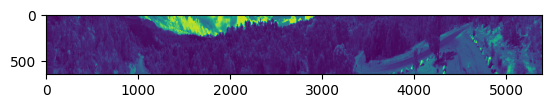

In [281]:
#load images
im_hyper = np.fromfile(fp_hyper,dtype='uint16')
im_hyper = (im_hyper-np.min(im_hyper))/(np.max(im_hyper)-np.min(im_hyper)) #nomralised
im_hyper = im_hyper.reshape([272,5389,640])

im_hyper =  np.transpose(im_hyper,(0,2,1))
plt.imshow(im_hyper[100,:,:])
plt.show()

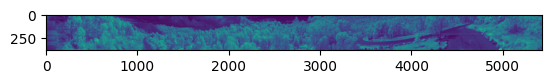

In [282]:
im_swir = np.fromfile(fp_swir,dtype='uint16')
im_swir = (im_swir-np.min(im_swir))/(np.max(im_swir)-np.min(im_swir)) #nomralised
im_swir = im_swir.reshape([288,5430,384])

im_swir =  np.transpose(im_swir,(0,2,1))
im_swir = np.fliplr(im_swir)

plt.imshow(im_swir[100,:,:])
plt.show()

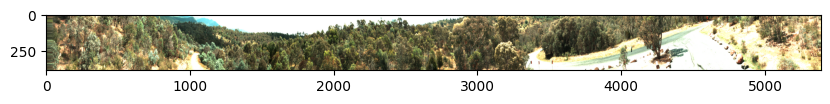

In [3]:
#downsize rgb image to do selection

rgb_swir = skimage.io.imread(fp_rgb_hyper)
rgb_resized = resize(rgb_swir, (rgb_swir.shape[0]*0.6,rgb_swir.shape[1]),anti_aliasing=True)
plt.figure(figsize=(10,10))
plt.imshow(rgb_resized)
plt.show()

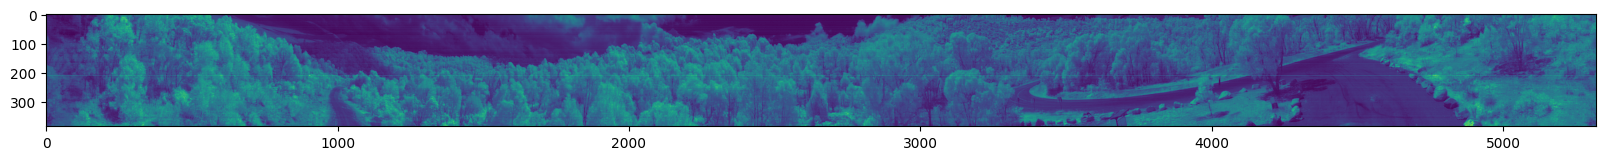

In [284]:
#take smaller crops of the same size from both\

#1 remove noise from sides of swir
plt.figure(figsize=(20,10))
swir = im_swir[:,:,90:im_swir.shape[2]-20]
plt.imshow(swir[100,:,:])

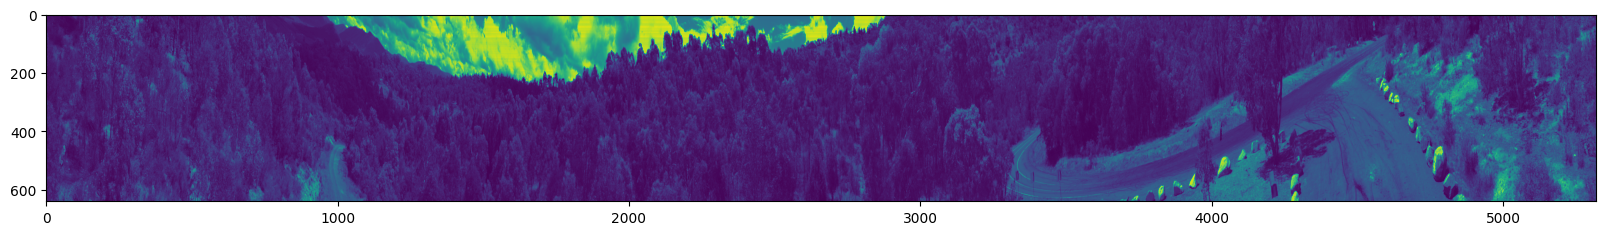

In [289]:
#2 clean up sides of hyper
plt.figure(figsize=(20,10))
hyp = im_hyper[:,:,39:im_hyper.shape[2]-30]
plt.imshow(hyp[100,:,:])

In [290]:
#ensure that htey are the same size, aligned etc
print('swir, hyp shape')
print(swir.shape, hyp.shape)

swir, hyp shape
(288, 384, 5320) (272, 640, 5320)


In [291]:
#resizing the hyper img, but only on the y axis 
# this can take a couple minutes to run
resized = zoom(hyp,(1,0.6,1))

In [293]:
#check both have the same x and y dimenions
print(swir.shape, resized.shape)

(288, 384, 5320) (272, 384, 5320)


In [294]:
##concatenate the data
SWIR_INDEX = 107 # which wavelength index to slice swir data at
swir_crop = swir[SWIR_INDEX:,:,:]  # take 95th wavelength and onwards, as before this just rubbish n noise
fuse = np.concatenate((resized,swir_crop),axis=0)

In [295]:
fuse.shape

(453, 384, 5320)

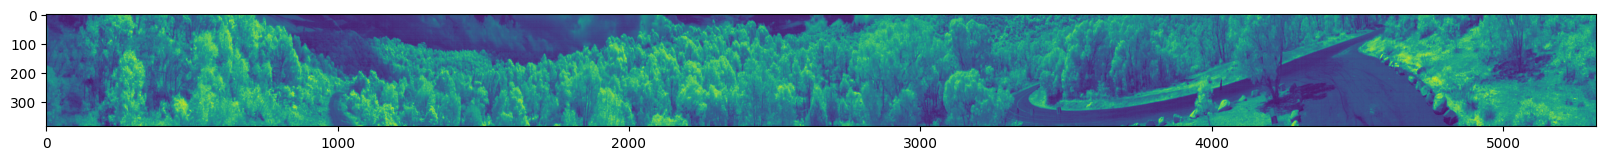

In [296]:
plt.figure(figsize=(20,10))
plt.imshow(fuse[250,:,:])

In [302]:
#initialise lists to hold training ROIs
#run this cell to clear the data or something
tree_trains = []
road_trains = []
dry_trains = []

%matplotlib qt

In [303]:
from matplotlib.widgets import EllipseSelector, RectangleSelector
import numpy as np
import matplotlib.pyplot as plt
# adapted from https://matplotlib.org/stable/gallery/widgets/rectangle_selector.html - see here for more info


#training data for tree
def select_callback(eclick, erelease):
    """
    Callback for line selection.

    *eclick* and *erelease* are the press and release events.
    """
    x1, y1 = int(eclick.xdata), int(eclick.ydata)
    x2, y2 = int(erelease.xdata), int(erelease.ydata)
    print(f"({x1}, {y1}) --> ({x2}, {y2})")
    # print(f"The buttons you used were: {eclick.button} {erelease.button}")
    roi = fuse[:,min(y1,y2):max(y1,y2),min(x1,x2):max(x1,x2)]
    tree_trains.append(roi)

fig, ax = plt.subplots(1,1,figsize=(20,10))
selectors = []
ax.imshow(rgb_resized)  # plot something
ax.set_title(f"Click and drag to draw a recntagle (tree)")
selectors.append(RectangleSelector(
    ax, select_callback,
    useblit=True,
    button=[1, 3],  # disable middle button
    minspanx=5, minspany=5,
    spancoords='pixels',
    interactive=True))
# fig.canvas.mpl_connect('key_press_event', keypress)
plt.show()

(1866, 231) --> (1956, 317)
(3731, 104) --> (3821, 187)
(4981, 90) --> (5003, 122)
(615, 75) --> (716, 173)


In [304]:
#training data for road
def select_callback(eclick, erelease):
    """
    Callback for line selection.

    *eclick* and *erelease* are the press and release events.
    """
    x1, y1 = int(eclick.xdata), int(eclick.ydata)
    x2, y2 = int(erelease.xdata), int(erelease.ydata)
    print(f"({x1}, {y1}) --> ({x2}, {y2})")
    # print(f"The buttons you used were: {eclick.button} {erelease.button}")
    roi = fuse[:,min(y1,y2):max(y1,y2),min(x1,x2):max(x1,x2)]
    road_trains.append(roi)

fig, ax = plt.subplots(1,1,figsize=(20,10))
selectors = []
ax.imshow(rgb_resized)  # plot something
ax.set_title(f"Click and drag to draw a recntagle (road)")
selectors.append(RectangleSelector(
    ax, select_callback,
    useblit=True,
    button=[1, 3],  # disable middle button
    minspanx=5, minspany=5,
    spancoords='pixels',
    interactive=True))
# fig.canvas.mpl_connect('key_press_event', keypress)
plt.show()

(1020, 350) --> (1067, 379)
(1016, 292) --> (1038, 314)
(3759, 314) --> (3825, 354)
(3890, 274) --> (3947, 310)
(4609, 278) --> (4732, 379)
(4490, 151) --> (4591, 227)


In [305]:
#training data for dry
def select_callback(eclick, erelease):
    """
    Callback for line selection.

    *eclick* and *erelease* are the press and release events.
    """
    x1, y1 = int(eclick.xdata), int(eclick.ydata)
    x2, y2 = int(erelease.xdata), int(erelease.ydata)
    print(f"({x1}, {y1}) --> ({x2}, {y2})")
    # print(f"The buttons you used were: {eclick.button} {erelease.button}")
    roi = fuse[:,min(y1,y2):max(y1,y2),min(x1,x2):max(x1,x2)]
    dry_trains.append(roi)

fig, ax = plt.subplots(1,1,figsize=(20,10))
selectors = []
ax.imshow(rgb_resized)  # plot something
ax.set_title(f"Click and drag to draw a recntagle (dry)")
selectors.append(RectangleSelector(
    ax, select_callback,
    useblit=True,
    button=[1, 3],  # disable middle button
    minspanx=5, minspany=5,
    spancoords='pixels',
    interactive=True))
# fig.canvas.mpl_connect('key_press_event', keypress)
plt.show()

(4132, 332) --> (4197, 364)
(4869, 151) --> (4927, 209)
(5006, 256) --> (5057, 317)
(3817, 271) --> (3861, 292)
(3694, 285) --> (3723, 307)
(4696, 79) --> (4750, 119)


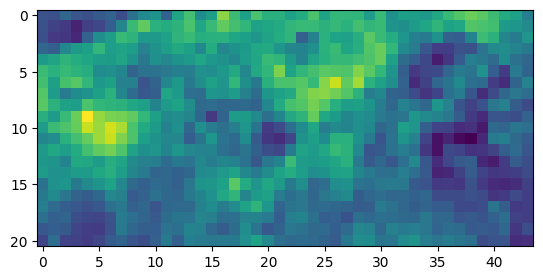

In [306]:
%matplotlib inline

#just visualising it to verify
plt.imshow(dry_trains[3][100,:,:])


In [308]:
training = [] # list to convert into df


def spectra_list(roi,idx):
    '''
    based on a region of interest and its associated class, converts all its spectra to a list, so that it can be added easily to a dataframe
    roi - region of interest from the source image
    idx - class of the region for the ML model
    '''
    tmp = []
    for i in range(roi[0,:,:].shape[1]):
        for j in range(roi[0,:,:].shape[0]):
            spectra = roi[:,j,i]
            tmp.append([idx,*spectra])
    roi_list = np.array(tmp)
    return roi_list


In [309]:
%matplotlib inline

In [310]:
#add all the training data to a list so it can be converted easily into a dataframe
for region in tree_trains:
    lst = spectra_list(region,1)
    training.append(lst)

for region in road_trains:
    lst = spectra_list(region,2)
    training.append(lst)

for region in dry_trains:
    lst = spectra_list(region,3)
    training.append(lst)

In [312]:
#create the data frame
training_df = pd.DataFrame(np.concatenate(training), columns=[['class']+list(np.arange(0,fuse.shape[0]))])
training_df.tail(5)

,class,0,1,2,3,4,5,6,7,8,...,443,444,445,446,447,448,449,450,451,452
64722,3.0,6.336231e-10,0.012481,0.017073,0.017362,0.019229,0.020910,0.020000,0.024910,0.026657,...,0.023356,0.025689,0.025400,0.027578,0.027044,0.026600,0.025889,0.024356,0.025956,0.024778
64723,3.0,-3.748163e-09,0.015576,0.016253,0.019770,0.018611,0.021816,0.024325,0.028799,0.029282,...,0.023067,0.026644,0.026022,0.027889,0.026178,0.027689,0.025111,0.024978,0.025422,0.026289
64724,3.0,-8.224696e-08,0.011900,0.014787,0.019374,0.020328,0.023918,0.023096,0.030660,0.028559,...,0.025289,0.024022,0.023578,0.027733,0.024356,0.025778,0.025978,0.025244,0.023622,0.023733
64725,3.0,-4.720745e-07,0.010063,0.013252,0.014887,0.016252,0.019979,0.017440,0.018391,0.019243,...,0.025000,0.024422,0.024511,0.024711,0.026200,0.025111,0.025667,0.024489,0.026711,0.024000
64726,3.0,2.634063e-06,0.012180,0.019869,0.022116,0.021898,0.025521,0.025451,0.029750,0.029419,...,0.022778,0.024356,0.024978,0.025089,0.025378,0.027089,0.025467,0.022533,0.022222,0.022867


In [313]:
#save the data frame to a csv - appending to any existing training data present
#randomly choose like 30-40 percent?

subset = training_df.sample(frac = 0.4)


subset.to_csv('spect_training_diffday.csv',mode='a',index=False,header=False)

CLASSIFICATION/SEGMENTATION + creating the classifier
* load training csv
* divide into attributes and classes
* choose an area to segment
* create a random forest classifier with the training data and run it over the area, outputting segmented image

In [391]:
#load training csv as df

df = pd.read_csv('spect_training_diffday.csv',header=None)

In [392]:
#divide into attributes and labels
train = df.iloc[:,1:454].values
labels = df.iloc[:,0].values #labels

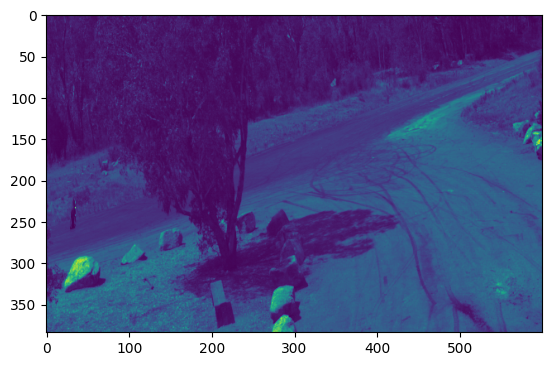

In [403]:
#choosing a test area to test training
# this just uses the image that was fused using the files loaded in at the top of this file
# can just skip to this step if you want to just use the classifier on an area without getting training data and stuff from it 
test_area = fuse[:,:,4000:4600]
plt.imshow(test_area[40,:,:])

In [404]:

#iterates through each pixel in the test region, transforming the spectra data into 1d list, then appends all the spectra data into a big list (tmp)
tmp = []
for i in range(test_area[0,:,:].shape[1]):
    for j in range(test_area[0,:,:].shape[0]):
        spectra = test_area[:,j,i]
        tmp.append(spectra)
test_area_list = np.array(tmp)
test_area_list = np.reshape(test_area_list,(test_area.shape[1],test_area.shape[2],test_area.shape[0]))

cover = np.zeros((test_area.shape[1],test_area.shape[2],3))
cover.shape

(384, 600, 3)

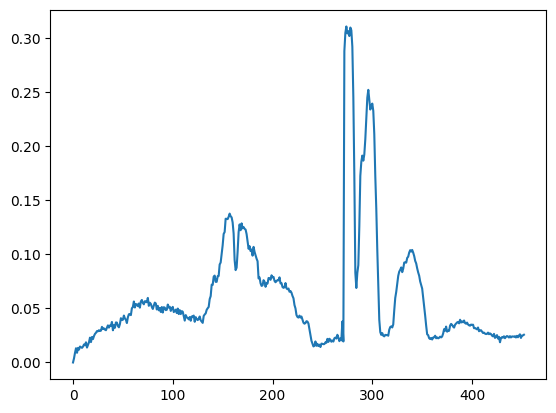

In [405]:
#plot a sample spectral signature from the previously created list to verify that it added correctly
plt.plot(np.array(np.arange(test_area_list[40,40,:].shape[0])),test_area_list[2,100,:])

In [406]:
clf = RandomForestClassifier() #initialise model
clf.fit(train,labels) #create a model using the training data loaded in previously

RandomForestClassifier()

In [407]:
# go through each pixel and its spectra and then predict what class it belongs to using the previously created classifier



for i in range(cover.shape[1]):
    for j in range(cover.shape[0]):
        pred = clf.predict(test_area[:,j,i].reshape(1,-1))[0]
        if (pred == 1): 
            cover[j][i][0] = 0/255
            cover[j][i][1] = 255/255 #green for alive
            cover[j][i][2] = 0/255
        if (pred == 2): 
            cover[j][i][0] = 179/255
            cover[j][i][1] = 154/255 #brown  for road/gravel
            cover[j][i][2] = 54/255
        if (pred == 3): 
            cover[j][i][0] = 255/255 #red dead
            cover[j][i][1] = 0/255
            cover[j][i][2] = 0/255

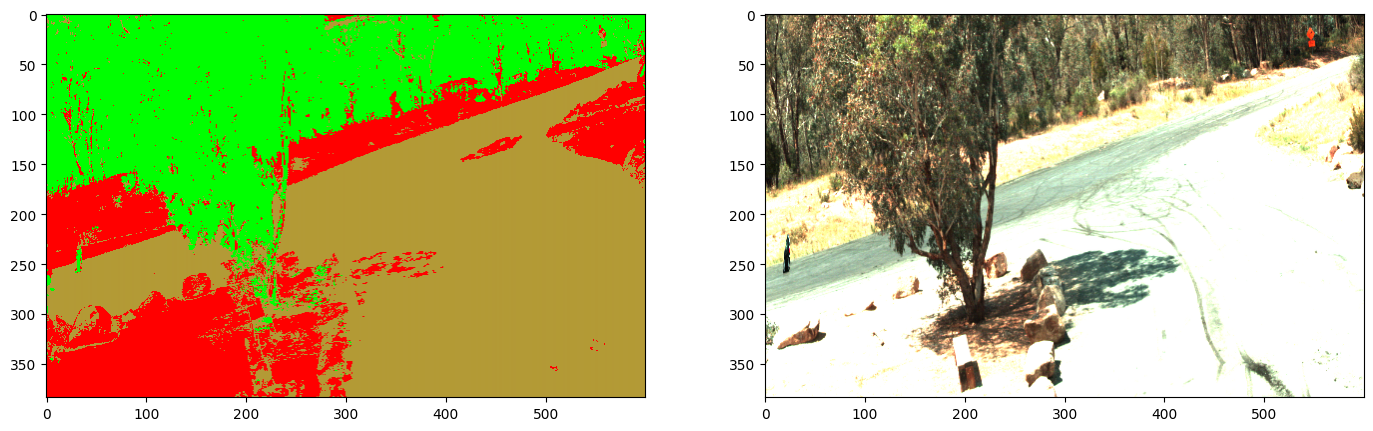

In [409]:
plt.figure(figsize=(17,12))
plt.subplot(1,2,1)
plt.imshow(cover)
plt.subplot(1,2,2)
plt.imshow(rgb_resized[:,4000+50:4600+50,:])
plt.show()


In [385]:
clf.predict(test_area[:,220,700].reshape(1,-1))[0]

3.0

TESTING ACCURACY

* load validation csv using pd
* run trained model on csv values other than the class value
* check if model result is equal to tested result

In [4]:
#create randm forest model for same day train data
sameday_train_df = pd.read_csv("spect_training_sameday-20220215.csv",header=None)
sameday_train = sameday_train_df.iloc[:,1:454].values
sameday_labels = sameday_train_df.iloc[:,0].values #labels
clf_sameday = RandomForestClassifier()
clf_sameday.fit(sameday_train,sameday_labels)

RandomForestClassifier()

In [6]:
#load validation set
validation_set = pd.read_csv("spect_validation.csv",header=None)

#divide into data and labels
val_data = validation_set.iloc[:,1:454].values
val_labels = validation_set.iloc[:,0].values #labels
# print(len(validation_set))


In [25]:
# iterate thru df and check whether the model predicted class is the same as the recorded class

correct_tree = 0 #1
correct_dry = 0 #3
correct_road = 0 #2
correct = 0

for idx,row in validation_set.iterrows():
    pred = clf_sameday.predict(np.array(row[1:]).reshape(1,-1))[0]
    if pred == row[0]:
        correct+=1
        if row[0] == 1:
            correct_tree+=1
        elif row[0] == 2:
            correct_road += 1
        elif row[0] == 3:
            correct_dry += 1

In [29]:
#note this result is thruogh having 3 images worth of fused training data from the same day, also validated against data from the same day
print(f'statistics')
print(f"percentage correctly classified (same day training): {100*correct/len(validation_set)}")
print(f"accuracy percentage by class:")
print(f"tree: {100*correct_tree/len(validation_set[validation_set.iloc[:,0] == 1])}, {len(validation_set[validation_set.iloc[:,0] == 1])} samples")
print(f"road: {100*correct_road/len(validation_set[validation_set.iloc[:,0] == 2])}, {len(validation_set[validation_set.iloc[:,0] == 2])} samples")
print(f"dry: {100*correct_dry/len(validation_set[validation_set.iloc[:,0] == 3])}, {len(validation_set[validation_set.iloc[:,0] == 3])} samples")


print(f'number of samples in validation set: {len(validation_set)}')
print(f'number of samples in training data set: {len(validation_set)}')

statistics
percentage correctly classified (diff day training): 98.33242421881087
accuracy percentage by class:
tree: 98.90437187533242, 18802 samples
road: 95.88970493493106, 7761 samples
dry: 99.01977211796246, 11936 samples
number of samples in validation set: 38499
number of samples in training data set: 38499


In [31]:
#create randm forest model for DIFFERENT day train data
diffday_train_df = pd.read_csv("spect_training_diffday.csv",header=None)
diffday_train = diffday_train_df.iloc[:,1:454].values
diffday_labels = diffday_train_df.iloc[:,0].values #labels
clf_diffday = RandomForestClassifier()
clf_diffday.fit(diffday_train,diffday_labels)

RandomForestClassifier()

In [35]:
correct_tree = 0 #1
correct_dry = 0 #3
correct_road = 0 #2
correct = 0

for idx,row in validation_set.iterrows():
    pred = clf_diffday.predict(np.array(row[1:]).reshape(1,-1))[0]
    if pred == row[0]:
        correct+=1
        if row[0] == 1:
            correct_tree+=1
        elif row[0] == 2:
            correct_road += 1
        elif row[0] == 3:
            correct_dry += 1

In [36]:
print(f'statistics')
print(f"percentage correctly classified (diff day training): {100*correct/len(validation_set)}")
print(f"accuracy percentage by class:")
print(f"tree: {100*correct_tree/len(validation_set[validation_set.iloc[:,0] == 1])}, {len(validation_set[validation_set.iloc[:,0] == 1])} samples")
print(f"road: {100*correct_road/len(validation_set[validation_set.iloc[:,0] == 2])}, {len(validation_set[validation_set.iloc[:,0] == 2])} samples")
print(f"dry: {100*correct_dry/len(validation_set[validation_set.iloc[:,0] == 3])}, {len(validation_set[validation_set.iloc[:,0] == 3])} samples")


print(f'number of samples in validation set: {len(validation_set)}')
print(f'number of samples in training data set: {len(validation_set)}')

statistics
percentage correctly classified (diff day training): 94.1375100651965
accuracy percentage by class:
tree: 99.5691947665142, 18802 samples
road: 90.74861486921789, 7761 samples
dry: 87.7848525469169, 11936 samples
number of samples in validation set: 38499
number of samples in training data set: 38499


In [ ]:
#joint df
joint_train_df = pd.concat([sameday_train_df,df])
joint_train_df = joint_train_df.sample(frac=0.5)
joint_train = joint_train_df.iloc[:,1:454].values
joint_labels = joint_train_df.iloc[:,0].values #labels
clf_joint = RandomForestClassifier()
clf_joint.fit(joint_train,joint_labels)

RandomForestClassifier()

In [360]:
correct = 0
for idx,row in validation_set.iterrows():
    pred = clf_joint.predict(np.array(row[1:]).reshape(1,-1))[0]
    if pred == row[0]:
        correct += 1

In [361]:
print(f'statistics')
print(f"percentage correctly classified (diff + same day (joint) training): {100*correct/len(validation_set)}")
print(f'number of samples in validation set: {len(validation_set)}')
print(f'number of samples in training data set: {len(joint_train_df)}')

statistics
percentage correctly classified (diff + same day (joint) training): 98.3246318086184
number of samples in validation set: 38499
number of samples in training data set: 75521
